Note, this work was done to dive more deeply into the GEE tutorial on SAR change detection used for the Explosion Explorer. Given one of the limitations revolved around SAR change detection from diferent look angles, I wanted to dive deeper into the statistics and practice of it so I can better understand how to automate it for explosion detection and future work on the app.

In [25]:
# IMPORTING LIBRARIES
import ee
import pandas as pd
import matplotlib.pyplot as plt
import geemap
import numpy as np
import datetime
import os
from scipy.stats import f, chi2
import time
import geopandas 

In [2]:
# Initialize Earth Engine
ee.Initialize()

In [3]:
# Creating EE geometries for AOI and date ranges
c = ee.Geometry.Point([35.51916, 33.90131])
g = c.buffer(2500)
md = ee.Date('2020-08-04')
sd = md.advance(-6, 'day')
ed = md.advance(6, 'day')

In [4]:
# Collecting Sentinel 1 GRD images for analysis
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(c)
                .filterDate(sd, ed)
                .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 94))
                .sort('system:time_start'))

In [5]:
# Dates images were collected
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['07/30/20', '08/05/20']

In [6]:
# Getting before/after images and clipping to AOI
im_list = im_coll.toList(im_coll.size())
before = ee.Image(im_list.get(0)).select('VV', 'VH')
after = ee.Image(im_list.get(1)).select('VV', 'VH')
before_clip = before.clip(g)
after_clip = after.clip(g)

In [7]:
# Print exact date/time images were collected
print(datetime.datetime.fromtimestamp(before.date().getInfo()['value']/1000.0).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.datetime.fromtimestamp(after.date().getInfo()['value']/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

2020-07-29 22:42:55
2020-08-04 22:43:35


In [8]:
# Visualize VV bands of before/after images
Map = geemap.Map()
Map.set_center(35.51916, 33.90131, zoom=12)
Map.addLayer(before_clip, {'bands':'VV', 'palette':['black', 'white']}, 'Before')
Map.addLayer(after_clip, {'bands':'VV', 'palette':['black', 'white']}, 'After')
Map

Map(center=[33.90131, 35.51916], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [9]:
# Converting to numpy array
before_np = geemap.ee_to_numpy(before, region=g)
after_np = geemap.ee_to_numpy(after, region=g)

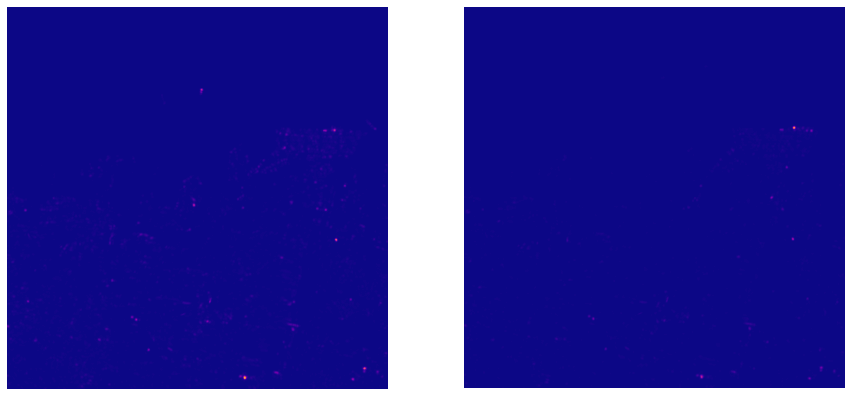

In [10]:
# Visualizing numpy array for hotspots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax1.imshow(before_np[:,:,0], cmap='plasma')
ax2.imshow(after_np[:,:,0], cmap='plasma')
for ax in (ax1, ax2):
    ax.axis('off')
plt.show()

In [11]:
# Getting pixel values ratio for analysis
ratio = after.divide(before)

In [12]:
# Converting ratio image to numpy array
ratio_np = geemap.ee_to_numpy(ratio, region=c.buffer(2500))
ratio_np.shape

(500, 499, 2)

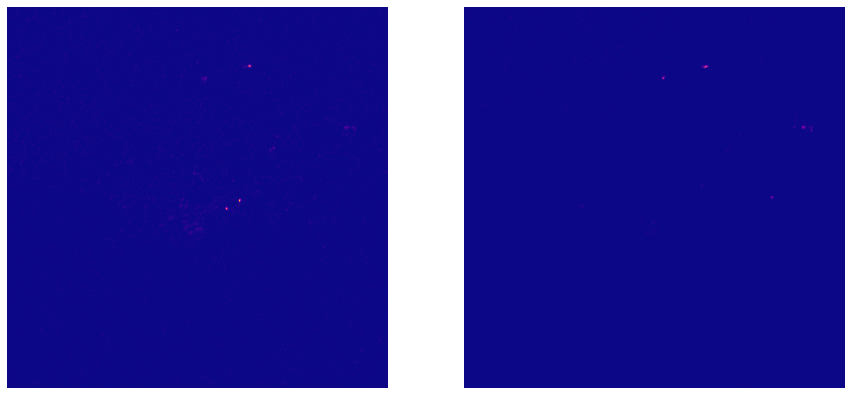

In [13]:
# Visualizing ratio for areas of higher return noise 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax1.imshow(ratio_np[:,:,1], cmap='plasma')
ax2.imshow(ratio_np[:,:,0], cmap='plasma')
for ax in (ax1, ax2):
    ax.axis('off')
plt.show()

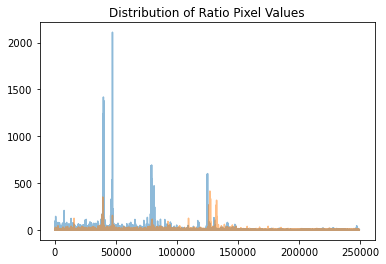

In [14]:
# Plotting pixel values distribution

plt.title('Distribution of Ratio Pixel Values')
plt.plot(ratio_np[:,:,0].ravel(), alpha=.5)
plt.plot(ratio_np[:,:,1].ravel(), alpha=.5)
plt.show()

In [15]:
# Creating a histogram and gathering the mean/variance
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), g).getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), g).getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), g).getInfo()

vv = np.array(hist['VV'])
vvx = vv[:,0]
vvy =  vv[:,1] / np.sum(vv[:,1])

vh = np.array(hist['VH'])
vhx = vh[:,0]
vhy =  vh[:,1] / np.sum(vh[:,1])

{'VH': 1.5570607851737899, 'VV': 2.167949281291227} 1.3333333333333333
{'VH': 10.163001604337602, 'VV': 129.98848853912804} 1.5555555555555556


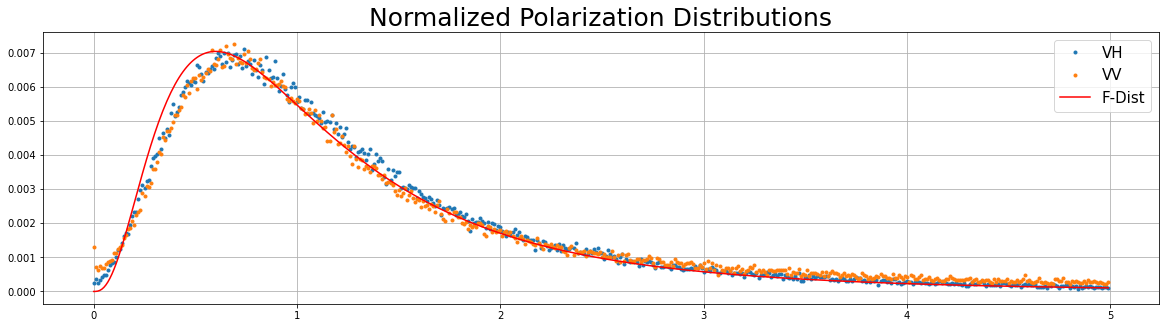

In [16]:
# Visualize normalized distributions with 4 looks and comparing against expected F-Distrubtion
# This is to determine whether 4 looks is appropriate for these images
# Less or more looks altered the f-distribution such that it no longer matched the bands
fig, ax = plt.subplots(figsize=(20,5))
m = 4
plt.grid()
ax.plot(vhx, vhy, '.', label='VH')
ax.plot(vvx, vvy, '.', label='VV')
ax.plot(vvx, f.pdf(vvx, 2*m, 2*m) / 100, '-r', label='F-Dist')
ax.legend(fontsize=15)
ax.set_title('Normalized Polarization Distributions', fontsize=25)

print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

plt.show()

In [17]:
im1 = before_clip
im2 = after_clip

In [18]:
# Returning an image expression of b1 * b2
def det(im):
    return im.expression('b(0) * b(1)')

# Number of looks.
m = 4

# Formula to determine the probability distribution of change between pixels
m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

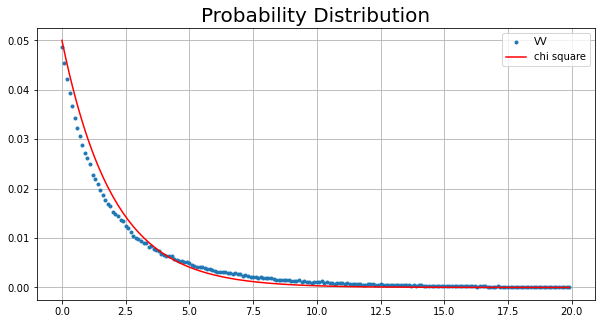

In [19]:
# Visualizing the histogram of probability distribution against chi square to  
# determine if the formula worked properly with 4 looks
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), g).getInfo()
a = np.array(hist['VV'])
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(x, y, '.', label='VV')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
ax.set_title('Probability Distribution', fontsize=20)
plt.grid()
plt.show()

In [30]:
# Creating chi square distribution function for df degrees of freedom
def chi2cdf(chi2, df):
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Multiplying areas > 0.05 p-value by 0
c_map = p_value.multiply(0).where(p_value.lt(0.05), 1)

# Masking areas of 0 to return only statistically significant change
c_map = c_map.updateMask(c_map.gt(0))

In [36]:
# Reading in Population data for Lebanon and shapefile
pop = ee.ImageCollection("WorldPop/GP/100m/pop").filterMetadata('country', 'equals', 'LBN')
shp = r'D:\Work\Masters\Digital Image Processing\Final Project\Reprojection\lebanon.shp'

# Clip image to lebanon boundaries for visualization
shp = geemap.shp_to_ee(shp)
c_map = c_map.clip(shp)

In [37]:
# Visualising damaged areas over population raster
Map = geemap.Map(add_google_map = False)
Map.set_center(35.51916, 33.90131, 13)
visualization = {
  'bands': ['population'],
  'min': 0.0,
  'max': 50.0,
  'palette': ['24126c', '1fff4f', 'd4ff50']}
Map.addLayer(pop, visualization, 'Population')
Map.addLayer(c_map, {'palette':['#ff0000']}, name='Damaged Areas')
Map

Map(center=[33.90131, 35.51916], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [38]:
# Convert damaged areas to integers
c_map_int = c_map.toInt()

# Reducing image to vectors 
c_map_vector = c_map_int.reduceToVectors(bestEffort=True)

In [39]:
# Calculating MAXIMUM zonal statistics for population within impacted areas
geemap.zonal_statistics(pop, c_map_vector, 'pop_stats.csv', statistics_type='MAXIMUM', scale=10)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to D:\Work\Masters\Digital Image Processing\Final Project\Submission\pop_stats.csv


In [40]:
# Reading in results and printing the accuacy
df = pd.read_csv('pop_stats.csv')
print(f"Estimated effected population: {round(df['LBN_2019_population'].dropna().sum())}")
print(f"Estimated accuracy: {round(300000 / df['LBN_2019_population'].dropna().sum()*100, 2)}")

Estimated effected population: 388090
Estimated accuracy: 77.3
